In [2]:
import os
import glob
import scipy.io as sio
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import itertools
from os import path
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
from analysis_functions import *

# Setup

In [4]:
monkey = 'Neville'

In [5]:
# TASK TIMING
sample = 550
delay1 = 1200 + sample
test1 = 550 + delay1
delay2 = 175 + test1
test2 = 550 + delay2
trial_epochs = [sample, delay1, test1, delay2, test2]

pv_stim_on_time = 400
pv_delay_time = 200

# STIMULUS CODE TIMES
SAMP_ON = 23
TEST_ON = 25
STRT_TRIAL = 9
STIM_ON = 23
PV_STIM_ON = 25
PV_STIM_OFF = 26
END_TRIAL = 18

# STIMULUS DIRECTIONS
dirs = [247.5, 225, 202.5, 67.5, 45, 22.5, 157.5, 135, 112.5, 337.5, 315, 292.5]

# BRAIN AREAS
brain_areas = ['MT', 'MST', 'LIP']

# BINNING/SMOOTHING PARAMETERS
bins = np.arange(-500, 3050)
n_bins = len(bins)-1
sm_std = 30 # gaussian smoothing stdev
bin_size = 100 # msec for binend data


# PATHS
datapath = 'E:\\two_boundary\\original_data\\'
figpath = 'E:\\two_boundary\\figures\\'
datapathsave = 'E:\\two_boundary\\data\\'

# PLOTTING COLORS
plot_colors = {'LIP':'#A7ACD9', 'MST':'#60712F', 'MT':'#FFCA47' }

save_filetype = ['png', 'pdf']

# MIN NUM TRIALS
min_ntrials = 250

# Data processing

In [46]:
window = np.arange(100, 400)

In [48]:
corr_all_areas = [[] for i in range(len(brain_areas))]
binned_dmc_all_areas = [[] for i in range(len(brain_areas))]
binned_pv_all_areas = [[] for i in range(len(brain_areas))]

all_data_dmc = [[] for i in range(len(brain_areas))]
all_data_pv = [[] for i in range(len(brain_areas))]

for i, area in enumerate(brain_areas):

    currpath = datapath + monkey + '\\' + area
    os.chdir(currpath)

    filelist = [f for f in glob.glob("*_merged_w_ratings.mat")]

    savepath = figpath + 'passive_viewing\\' + monkey + '\\' + area + '\\'
    
    dmc_data = []
    pv_data = []
    
    binned_dmc = []
    binned_pv = []
    
    corr_all = []

    for fname in filelist:
        [pv, dmc, spikes_binned_dmc, spikes_binned_pv, corrs, all_dmc, all_pv] = passive_viewing_analysis(fname, area, monkey, window, savepath)

        pv_rate_all.append(pv)
        dmc_rate_all.append(dmc)

        corr_all.append(corrs)
        
        if len(dmc_data) > 0:
            if len(all_dmc) > 0:
                dmc_data = np.concatenate([dmc_data, all_dmc], 0)
                pv_data = np.concatenate([pv_data, all_pv], 0)
                binned_dmc = np.concatenate([binned_dmc, spikes_binned_dmc], 0)
                binned_pv = np.concatenate([binned_pv, spikes_binned_pv], 0)
                
        else:
            dmc_data = all_dmc
            pv_data = all_pv            
            binned_dmc = spikes_binned_dmc
            binned_pv = spikes_binned_pv
            
    all_data_dmc[i] = dmc_data
    all_data_pv[i] = pv_data
    
    binned_dmc_all_areas[i] = binned_dmc
    binned_pv_all_areas[i] = binned_pv
    
    corr_all_areas[i] = np.hstack(corr_all)


# Decoding

## Sliding window

### Category

In [29]:
n_iter = 300
n_trials = 30
time_points = np.arange(0, len(window))


cat_perf_dmc_all = {}
cat_perf_pv_all = {}

for i, area in enumerate(brain_areas):
    all_data = binned_dmc_all_areas[i]
    n_neurons_decoder = np.size(all_data, 0)
    n_neurons_total = np.size(all_data, 0)
    
    cat_perf_dmc = category_decoder(n_iter, time_points, n_neurons_decoder, n_neurons_total, n_trials, all_data)    
    cat_perf_dmc_all[area] = cat_perf_dmc


    all_data = binned_pv_all_areas[i]
    cat_perf_pv = category_decoder(n_iter, time_points, n_neurons_decoder, n_neurons_total, n_trials, all_data)    
    cat_perf_pv_all[area] = cat_perf_pv

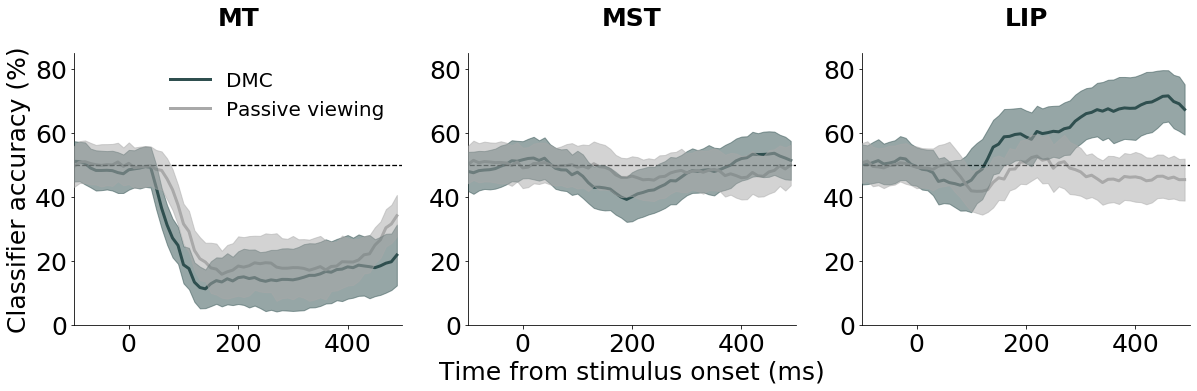

In [45]:
x = np.arange(-100, 500, 10)
fig, ax =  plt.subplots(1, 3, figsize=(20, 5))

for i, area in enumerate(brain_areas):
    currmean = np.mean(cat_perf_dmc_all[area], 0)
    currstd = np.std(cat_perf_dmc_all[area], 0)  

    ax[i].plot(x, currmean, color =  'darkslategrey',  lw = 3, label = 'DMC')
    ax[i].fill_between(x, currmean-currstd, currmean+currstd, color = 'darkslategrey',  lw = 1., alpha = 0.5, zorder=20)
    
    currmean = np.mean(cat_perf_pv_all[area], 0)
    currstd = np.std(cat_perf_pv_all[area], 0)
    
    ax[i].plot(x, currmean, color = 'darkgrey',  lw = 3, label = 'Passive viewing')
    ax[i].fill_between(x, currmean-currstd, currmean+currstd, color = 'darkgrey',  lw = 1., alpha = 0.5, zorder=20)
        
    ax[i].plot([-400, 3000], [50, 50], '--k', lw = 1.3)
    
    ax[i].set_xlim(-100, 500)
    ax[i].set_ylim(0, 85)
    ax[i].tick_params(labelsize=25)
    ax[i].set_title(brain_areas[i], fontsize = 25, y=1.08, fontweight='bold')

# Hide the right and top spines
for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    #ax[i].set_ylim(0, 0.0016)

ax[0].set_ylabel('Classifier accuracy (%)', fontsize = 25)
ax[1].set_xlabel('Time from stimulus onset (ms)', fontsize = 25)
ax[0].legend(frameon = False, fontsize = 20)

plt.show()

for i in save_filetype:
    savepath = figpath + 'passive_viewing\\' + monkey + '_category_decoder_sliding_window.' + i
    fig.savefig(savepath, bbox_inches='tight')

### Direction

In [38]:
n_trials = 5
time_points = np.arange(0, len(window))

dir_perf_dmc_all = {}
dir_perf_pv_all = {}

for i, area in enumerate(brain_areas):
    all_data = binned_dmc_all_areas[i]
    n_neurons_decoder = np.size(all_data, 0)
    n_neurons_total = np.size(all_data, 0)
    
    perf_dmc = direction_decoder(n_iter, time_points, n_neurons_decoder, n_neurons_total, n_trials, all_data)    
    dir_perf_dmc_all[area] = perf_dmc


    all_data = binned_pv_all_areas[i]
    perf_pv = direction_decoder(n_iter, time_points, n_neurons_decoder, n_neurons_total, n_trials, all_data)    
    dir_perf_pv_all[area] = perf_pv

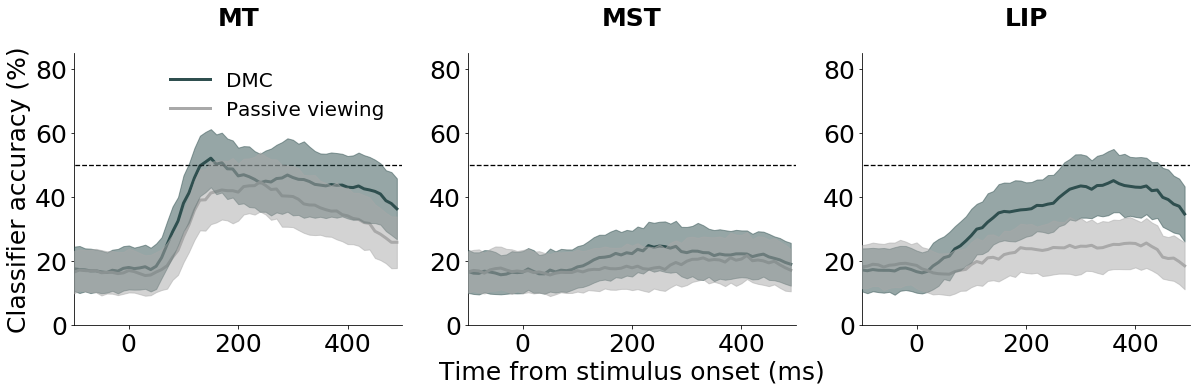

In [44]:
x = np.arange(-100, 500, 10)
fig, ax =  plt.subplots(1, 3, figsize=(20, 5))

for i, area in enumerate(brain_areas):
    currmean = np.mean(dir_perf_dmc_all[area], 0)
    currstd = np.std(dir_perf_dmc_all[area], 0)  

    ax[i].plot(x, currmean, color =  'darkslategrey',  lw = 3, label = 'DMC')
    ax[i].fill_between(x, currmean-currstd, currmean+currstd, color = 'darkslategrey',  lw = 1., alpha = 0.5, zorder=20)
    
    currmean = np.mean(dir_perf_pv_all[area], 0)
    currstd = np.std(dir_perf_pv_all[area], 0)
    
    ax[i].plot(x, currmean, color = 'darkgrey',  lw = 3, label = 'Passive viewing')
    ax[i].fill_between(x, currmean-currstd, currmean+currstd, color = 'darkgrey',  lw = 1., alpha = 0.5, zorder=20)
        
    ax[i].plot([-400, 3000], [50, 50], '--k', lw = 1.3)
    
    ax[i].set_xlim(-100, 500)
    ax[i].set_ylim(0, 85)
    ax[i].tick_params(labelsize=25)
    ax[i].set_title(brain_areas[i], fontsize = 25, y=1.08, fontweight='bold')

# Hide the right and top spines
for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    #ax[i].set_ylim(0, 0.0016)

ax[0].set_ylabel('Classifier accuracy (%)', fontsize = 25)
ax[1].set_xlabel('Time from stimulus onset (ms)', fontsize = 25)
ax[0].legend(frameon = False, fontsize = 20)

plt.show()

for i in save_filetype:
    savepath = figpath + 'passive_viewing\\' + monkey + '_direction_decoder_sliding_window.' + i
    fig.savefig(savepath, bbox_inches='tight')

## Mean across epoch

In [76]:
n_iter = 500

dmc_perf = [[] for i in range(3)]
pv_perf = [[] for i in range(3)]

for indx in range(3):
    dmc_perf[indx] = category_decoder_epoch(all_data_dmc[indx], n_iter, len(all_data_dmc[indx]), len(all_data_dmc[indx]), 20)
    pv_perf[indx] = category_decoder_epoch(all_data_pv[indx], n_iter, len(all_data_dmc[indx]), len(all_data_dmc[indx]), 20)
    
dmc_perf_dir = [[] for i in range(3)]
pv_perf_dir = [[] for i in range(3)]

for indx in range(3):
    dmc_perf_dir[indx] = direction_decoder_epoch(all_data_dmc[indx], n_iter, len(all_data_dmc[indx]), len(all_data_dmc[indx]), 5)
    pv_perf_dir[indx] = direction_decoder_epoch(all_data_pv[indx], n_iter, len(all_data_dmc[indx]), len(all_data_dmc[indx]), 5)

#### Permutation test for sig

In [51]:
n_shuffle = 5000
pvals_cat = shuffle_decoder(dmc_perf, pv_perf, n_shuffle)
pvals_dir = shuffle_decoder(dmc_perf_dir, pv_perf_dir, n_shuffle)

### Plot direction decoder

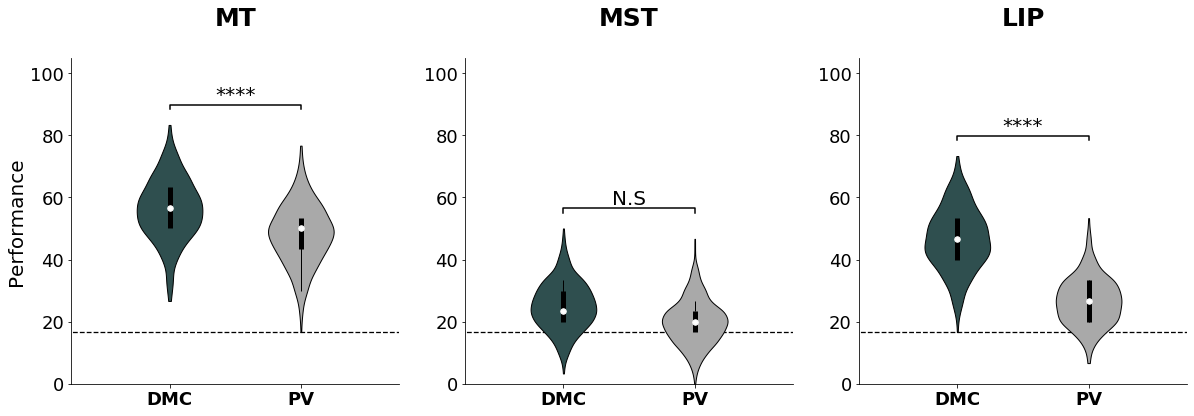

In [70]:
violin_colors = ['darkslategrey', 'darkgrey']

fig, ax =  plt.subplots(1, 3, figsize=(20, 6))
x1, x2 = 1, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())

for i in range(3):
    
    data = [dmc_perf_dir[i], pv_perf_dir[i]]
    
    parts = ax[i].violinplot(data, showmeans=False, showmedians=False, showextrema=False)
    for ii, pc in enumerate(parts['bodies']):
        pc.set_facecolor(violin_colors[ii])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        
    quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

    inds = np.arange(1, len(medians) + 1)
    ax[i].scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    ax[i].vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax[i].vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)
    
    ax[i].set_title(brain_areas[i], fontsize = 25, y=1.08, fontweight='bold')
    
    ax[i].plot([0, 3], [1/6*100, 1/6*100], '--k', lw = 1.3, zorder = 0)
    ax[i].tick_params(labelsize=18)
                 
    if pvals_dir[i] > 0.05:
        sigtext = 'n.s'
    elif pvals_dir[i] <= 0.05 and pvals_dir[i] > 0.01:
        sigtext = '*'                 
    elif pvals_dir[i] <= 0.01 and pvals_dir[i] > 0.005:
        sigtext = '**'      
    elif pvals_dir[i] <= 0.005 and pvals_dir[i] > 0.005:
        sigtext = '***'  
    else:
        sigtext = '****'      
                 
                 
    y, h, col = np.max(data) + 5, 1.5, 'k'
    #y, h, col = 100, 1.5, 'k'
    ax[i].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax[i].text((x1+x2)*.5, y+h, sigtext, ha='center', va='bottom', color=col, fontsize = 20)

    
# Hide the right and top spines
for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    #ax[i].set_ylim(0, 0.0016)

ax[0].set_ylabel('Performance', fontsize = 20)

ax[0].set_ylim(0, 105)
ax[1].set_ylim(0, 105)
ax[2].set_ylim(0, 105)

# set style for the axes
labels = ['DMC', 'PV']
for ax in [ax[0], ax[1], ax[2]]:
    set_axis_style(ax, labels)
    
plt.show()

for i in save_filetype:
    savepath = figpath + 'passive_viewing\\' + monkey + '_direction_decoder_violin_plot_100_400.' + i
    fig.savefig(savepath, bbox_inches='tight')


### Plot category decoder

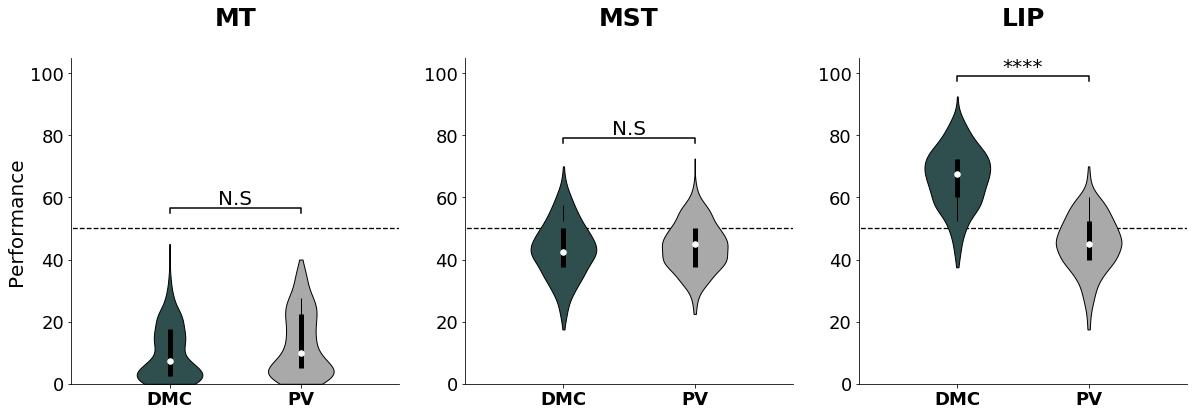

In [71]:
violin_colors = ['darkslategrey', 'darkgrey']

fig, ax =  plt.subplots(1, 3, figsize=(20, 6))

for i in range(3):
    
    data = [dmc_perf[i], pv_perf[i]]
    
    parts = ax[i].violinplot(data, showmeans=False, showmedians=False, showextrema=False)
    for ii, pc in enumerate(parts['bodies']):
        pc.set_facecolor(violin_colors[ii])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        
    quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

    inds = np.arange(1, len(medians) + 1)
    ax[i].scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    ax[i].vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax[i].vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)
    
    ax[i].set_title(brain_areas[i], fontsize = 25, y=1.08, fontweight='bold')
    
    ax[i].plot([0, 3], [50, 50], '--k', lw = 1.3, zorder = 0)
    ax[i].tick_params(labelsize=18)
    
    if pvals_cat[i] > 0.05:
        sigtext = 'n.s'
    elif pvals_cat[i] <= 0.05 and pvals_cat[i] > 0.01:
        sigtext = '*'                 
    elif pvals_cat[i] <= 0.01 and pvals_cat[i] > 0.005:
        sigtext = '**'      
    elif pvals_cat[i] <= 0.005 and pvals_cat[i] > 0.005:
        sigtext = '***'  
    else:
        sigtext = '****'      
    
    if abs(np.max(data) + 5)-50 > 5:
        y = np.max(data) + 5
    else:
        y = 55                
                 
    h, col = 1.5, 'k'
    ax[i].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax[i].text((x1+x2)*.5, y+h, sigtext, ha='center', va='bottom', color=col, fontsize = 20)
    

# Hide the right and top spines
for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    #ax[i].set_ylim(0, 0.0016)

ax[0].set_ylabel('Performance', fontsize = 20)


ax[0].set_ylim(0, 105)
ax[1].set_ylim(0, 105)
ax[2].set_ylim(0, 105)

# set style for the axes
labels = ['DMC', 'PV']
for ax in [ax[0], ax[1], ax[2]]:
    set_axis_style(ax, labels)
    
plt.show()

for i in save_filetype:
    savepath = figpath + 'passive_viewing\\' + monkey + '_category_decoder_violin_plot_100_400.' + i
    fig.savefig(savepath, bbox_inches='tight')


## Plot correlations

(144,)

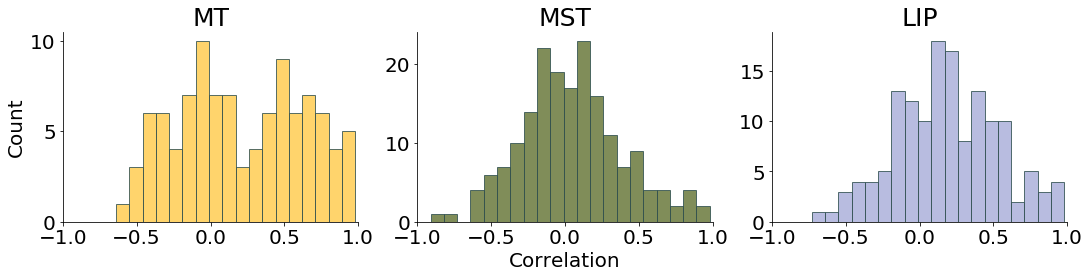

In [60]:
fig, ax =  plt.subplots(1, 3, figsize=(18, 3.5))

for i, area in enumerate(brain_areas):
    ax[i].hist(corr_all_areas[i], bins = np.arange(-1, 1, 0.09), edgecolor = 'darkslategrey', alpha = 0.8, density = False, facecolor = plot_colors[area], label = brain_areas[i])
    ax[i].set_title(area, fontsize = 25)
    ax[i].set_xlim(-1, 1)
    ax[i].tick_params(labelsize=20)
#    ax[i].set_ylim(0, 25)

    
ax[0].set_ylabel('Count', fontsize = 20)
ax[1].set_xlabel('Correlation', fontsize = 20)

# Hide the right and top spines
for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)


plt.show()
for i in save_filetype:
    savepath = figpath + 'passive_viewing\\' + monkey + 'pv_dmc_corr.' + i
    fig.savefig(savepath, bbox_inches='tight')


In [61]:
[x_MT, y_MT] = ecdf(corr_all_areas[2])
[x_MST, y_MST] = ecdf(corr_all_areas[1])
[x_LIP, y_LIP] = ecdf(corr_all_areas[0])

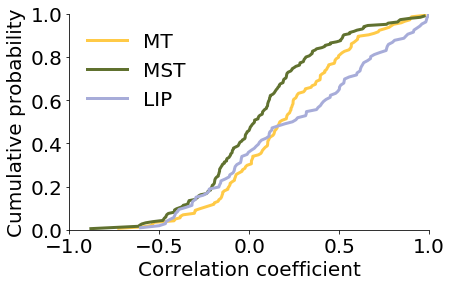

In [62]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([1,1,1,1])

ax.plot(x_MT, y_MT, color = plot_colors['MT'], lw = 3, label = 'MT')
ax.plot(x_MST, y_MST, color =  plot_colors['MST'], lw = 3, label = 'MST')
ax.plot(x_LIP, y_LIP, color =  plot_colors['LIP'], lw = 3, label = 'LIP')

ax.set_xlabel('Correlation coefficient', fontsize = 20)
ax.set_ylabel('Cumulative probability', fontsize = 20)
plt.xlim(-1, 1)
plt.ylim(0, 1)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(labelsize=20)

ax.legend(frameon = False, fontsize = 20)

plt.show()
for i in save_filetype:
    savepath = figpath + 'passive_viewing\\' + monkey + 'pv_dmc_corr_ecdf.' + i
    fig.savefig(savepath, bbox_inches='tight')
